
* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocesamiento

### Leer los datos y almacenarlos por año

In [2]:
dfs = {}
for year in range(1995, 2016):
    dfs[str(year)] = pd.read_excel(f'./datos/precios/Precio_Bolsa_Nacional_($kwh)_{year}.xlsx')

for year in range(2016, 2019):
    dfs[str(year)] = pd.read_excel(f'./datos/precios/Precio_Bolsa_Nacional_($kwh)_{year}.xls')
    
dfs.keys()

dict_keys(['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'])

In [3]:
dfs['1995'].head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,Precio Bolsa Nacional ($/kWh) 1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fecha,0.000,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,...,14.000,15.000,16.000,17.000,18.000,19.000,20.000,21.000,22.000,23.000
3,1995-07-20,NaN,1.073,1.073,1.073,1.073,1.073,1.073,1.073,1.074,...,1.073,1.073,1.073,1.073,1.074,1.897,1.897,1.897,1.073,1.073
4,1995-07-21,1.073,1.000,1.000,1.000,1.000,1.000,5.000,6.000,6.000,...,5.000,1.000,1.000,5.000,12.000,16.670,11.929,5.000,1.000,1.000


**Renombrar columnas, eliminar las primeras filas invalidas, eliminar filas duplicadas y calcular el promedio por día**

In [4]:
def preprocessing_columnsname_duplicates(df_y, year):
    df = df_y.copy()

    # renombrar las columnas del dataframe
    columns = np.squeeze(df.loc[df[df.columns[0]] == 'Fecha'].values)
    lindex = int(df.loc[df[df.columns[0]] == 'Fecha'].index.values) + 1
    df.columns = columns
    # eliminar las filas primeras filas invalidas
    df = df.drop(list(range(0, lindex)))
    
    # eliminar filas duplicadas
    shp_old = df.shape[0]
    df = df.drop_duplicates()
    print(f'Dataframe {year}, Final shape: {df.shape}, duplicates: {shp_old - df.shape[0]}')

    return df


def generate_average_kWh(df_y):
    # Calcular promedio de los kWh
    df = pd.DataFrame()
    df['Fecha'] = df_y['Fecha']
    df['mean'] = df_y.mean(axis=1)
    return df

In [5]:
for year in range(1995, 2019):
    year = str(year)
    dfs[year] = preprocessing_columnsname_duplicates(dfs[year], year)
    dfs[year] = generate_average_kWh(dfs[year])

Dataframe 1995, Final shape: (165, 25), duplicates: 0
Dataframe 1996, Final shape: (371, 25), duplicates: 7
Dataframe 1997, Final shape: (365, 25), duplicates: 0
Dataframe 1998, Final shape: (368, 25), duplicates: 19
Dataframe 1999, Final shape: (367, 25), duplicates: 7
Dataframe 2000, Final shape: (366, 26), duplicates: 0
Dataframe 2001, Final shape: (365, 25), duplicates: 0
Dataframe 2002, Final shape: (365, 25), duplicates: 0
Dataframe 2003, Final shape: (365, 25), duplicates: 0
Dataframe 2004, Final shape: (366, 25), duplicates: 0
Dataframe 2005, Final shape: (365, 26), duplicates: 0
Dataframe 2006, Final shape: (365, 25), duplicates: 0
Dataframe 2007, Final shape: (368, 25), duplicates: 11
Dataframe 2008, Final shape: (366, 25), duplicates: 0
Dataframe 2009, Final shape: (367, 25), duplicates: 15
Dataframe 2010, Final shape: (365, 26), duplicates: 0
Dataframe 2011, Final shape: (367, 27), duplicates: 2
Dataframe 2012, Final shape: (367, 27), duplicates: 0
Dataframe 2013, Final sha

**Concatenar los años y eliminar filas na**

In [6]:
years = sorted(list(dfs))
df_concatenated = pd.concat([dfs[y] for y in years], axis=0)

print(df_concatenated.shape)
df_concatenated = df_concatenated.dropna()
print(df_concatenated.shape)
df_concatenated.head()

(8348, 2)
(8341, 2)


,Fecha,mean
3,1995-07-20,1.409435
4,1995-07-21,4.924333
5,1995-07-22,1.269500
6,1995-07-23,0.953083
7,1995-07-24,4.305917


**Gráfica kWh promedio desde el año 1995 al 2018**

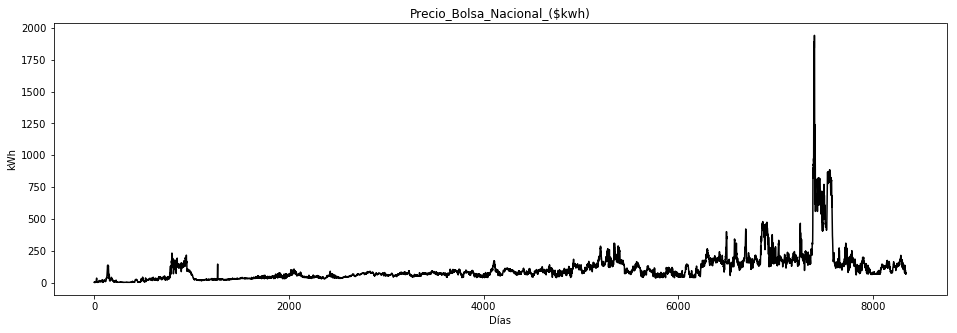

In [7]:
plt.figure(figsize=(16,5))
plt.title('Precio_Bolsa_Nacional_($kwh)')
plt.xlabel('Días')
plt.ylabel('kWh')
plt.plot(df_concatenated['mean'].values, color='black');

## Transformación Box-Cox

In [8]:
from sklearn.preprocessing import PowerTransformer

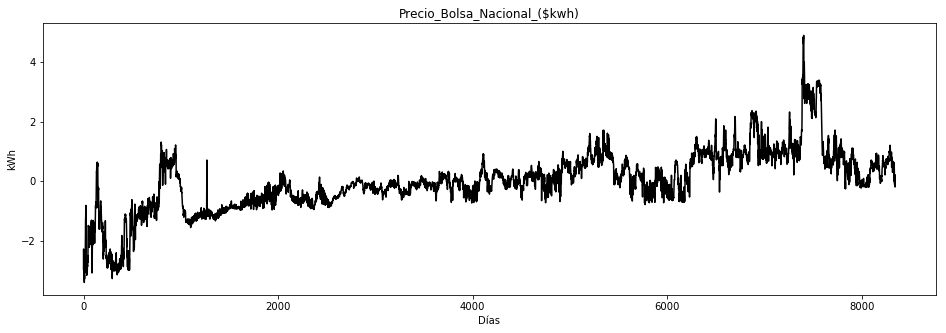

In [9]:
boxcox = PowerTransformer(method='box-cox')
df_transformed = boxcox.fit_transform(df_concatenated['mean'].values.reshape(-1, 1))

plt.figure(figsize=(16,5))
plt.title('Precio_Bolsa_Nacional_($kwh)')
plt.xlabel('Días')
plt.ylabel('kWh')
plt.plot(
    df_transformed,
    color='black'
);